In [1]:
import torch
from torch import nn
import random
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import spacy
import copy
from tqdm import tqdm
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

from matplotlib import font_manager
font = font_manager.FontProperties(fname="simhei.ttf")
plt.rcParams['axes.unicode_minus']=False

In [2]:
class NMTDataset(Dataset):
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg

    def __len__(self):
        return len(self.src)

    def __getitem__(self, index):
        return {
            'src': self.src[index]['sentence'],
            'src_len': self.src[index]['len'],
            'trg': self.trg[index]['sentence'],
            'trg_len': self.trg[index]['len']
        }

In [3]:
spacy_en = spacy.load('en')
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [4]:
class NMTDataset(Dataset):
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg

    def __len__(self):
        return len(self.src)

    def __getitem__(self, index):
        return {
            'src': self.src[index]['sentence'],
            'src_len': self.src[index]['len'],
            'trg': self.trg[index]['sentence'],
            'trg_len': self.trg[index]['len']
        }

In [5]:
with open('cmn.txt', 'r', encoding='utf-8') as f:
        data = f.read()

data = data.strip().split('\n')

print('number of examples: ', len(data))

en_data = [line.split('\t')[0] for line in data]
zh_data = [line.split('\t')[1] for line in data]

assert len(en_data) == len(zh_data)

number of examples:  23610


In [6]:
zh_words = set()
en_words = set()

for i in tqdm(range(len(zh_data))):
    en_seg = tokenize_en(en_data[i])
    zh_seg = list(zh_data[i])

    zh_words.update(zh_seg)
    en_words.update(en_seg)

100%|██████████| 23610/23610 [00:02<00:00, 11536.23it/s]


In [7]:
zh_word2idx = {value: index + 4 for index, value in enumerate(zh_words)}

zh_word2idx['<pad>'] = 0
zh_word2idx['<sos>'] = 1
zh_word2idx['<eos>'] = 2
zh_word2idx['<unk>'] = 3

zh_idx2word = {zh_word2idx[k]: k for k in zh_word2idx.keys()}

In [8]:
en_word2idx = {value: index + 4 for index, value in enumerate(en_words)}

en_word2idx['<pad>'] = 0
en_word2idx['<sos>'] = 1
en_word2idx['<eos>'] = 2
en_word2idx['<unk>'] = 3

en_idx2word = {en_word2idx[k]: k for k in en_word2idx.keys()}

In [9]:
zh = []
en = []

zh_max_len = -1
en_max_len = -1

for i in tqdm(range(len(zh_data))):
    en_seg = tokenize_en(en_data[i])
    zh_seg = list(zh_data[i])

    en_sentence = [en_word2idx['<sos>']] + [en_word2idx[w] for w in en_seg] + [en_word2idx['<eos>']]
    zh_sentence = [zh_word2idx['<sos>']] + [zh_word2idx[w] for w in zh_seg] + [zh_word2idx['<eos>']]

    en_len = len(en_sentence)
    zh_len = len(zh_sentence)
    
    if en_len > en_max_len:
        en_max_len = en_len
    
    if zh_len > zh_max_len:
        zh_max_len = zh_len
    
    zh.append({
         'sentence': zh_sentence,
         'len': zh_len
    })
    en.append({
        'sentence': en_sentence,
        'len': en_len
    })

100%|██████████| 23610/23610 [00:01<00:00, 12069.58it/s]


In [10]:
en_max_len

38

In [11]:
zh_max_len

46

In [12]:
def padding_batch(batch):

    src_lens = [d["src_len"] for d in batch]
    trg_lens = [d["trg_len"] for d in batch]

    src_max = max([d["src_len"] for d in batch])
    trg_max = max([d["trg_len"] for d in batch])

    srcs = []
    trgs = []

    for d in batch:
        src = copy.deepcopy(d['src'])
        trg = copy.deepcopy(d['trg'])

        src.extend([en_word2idx["<pad>"]]*(src_max-d["src_len"]))
        trg.extend([zh_word2idx["<pad>"]]*(trg_max-d["trg_len"]))

        srcs.append(src)
        trgs.append(trg)

    srcs = torch.tensor(srcs, dtype=torch.long, device=DEVICE)
    trgs = torch.tensor(trgs, dtype=torch.long, device=DEVICE)

    batch = {"src":srcs, "src_lens":src_lens,
             "trg":trgs, "trg_lens":trg_lens}
    return batch

In [13]:
class PositionwiseFeedforwardLayer(nn.Module):
    
    def __init__(self, d_model, d_ff, dropout):
        
        super().__init__()
        
        self.fc_1 = nn.Linear(d_model, d_ff)
        self.fc_2 = nn.Linear(d_ff, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x):
        
        # x [batch_size, seq_len, d_model]
        x = self.dropout(F.relu(self.fc_1(x)))
        
        x = self.fc_2(x)
        
        return x

In [14]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout, device):
        
        super().__init__()
        
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        
        self.fc_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.d_head])).to(device)
        
    def forward(self, query, key, value, mask=None):
        
        batch_size = query.shape[0]
        
        # query [batch_size, query_len, d_model]
        # key [batch_size, key_len, d_model]
        # value [batch_size, value_len, d_model]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        Q = Q.view(batch_size, -1, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        
        # Q [batch_size, n_heads, query_len, d_head]
        # K [batch_size, n_heads, key_len, d_head]
        # V [batch_size, n_heads, value_len, d_head]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        # energy [batch_size, n_heads, query_len, key_len]
        
        if mask is not None:
            energy = torch.masked_fill(energy, mask == 0, -1e10)
        
        attention = F.softmax(energy, dim=-1)
        
        # attention
        x = torch.matmul(self.dropout(attention), V)
        
        # x [batch_size, n_heads, query_len, d_head]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        # x [batch_size, query_len, n_heads, d_head]
        
        x = x.view(batch_size, -1, self.d_model)
        
        # x [batch_size, query_len, d_model]
        
        return x, attention

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff,
                 dropout, device):
        
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.ff_layer_norm = nn.LayerNorm(d_model)
        self.self_attention = MultiHeadAttentionLayer(d_model, n_heads,
                                                      dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(d_model,
                                                                     d_ff,
                                                                     dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        # src [batch_size, src_len, d_model]
        # src_mask []
        
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        _src = self.positionwise_feedforward(src)
        
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        return src

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layers, 
                 n_heads, d_ff, dropout, device,
                 max_len=100):
        
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
        self.layers = nn.ModuleList([EncoderLayer(d_model,
                                                  n_heads,
                                                  d_ff,
                                                  dropout,
                                                  device)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)

            
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)

        
    def forward(self, src, src_mask):
        
        # src [batch_size, src_len]
        # src_mask [batch_size, 1, 1, src_len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0) \
                                      .repeat(batch_size, 1) \
                                      .to(self.device)
        
        src = self.dropout(self.tok_embedding(src) * self.scale + \
                           self.pos_embedding(pos))
        
        for layer in self.layers:
            src = layer(src, src_mask)
        
        return src

In [17]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff,
                 dropout, device):
        
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model)
        self.ff_layer_norm = nn.LayerNorm(d_model)
        
        self.self_attention = MultiHeadAttentionLayer(d_model, n_heads,
                                                      dropout, device)
        
        self.encoder_attention = MultiHeadAttentionLayer(d_model, n_heads,
                                                         dropout, device)
        
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(d_model,
                                                                     d_ff, 
                                                                     dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # trg [batch_size, trg_len, d_model]
        # enc_src [batch_size, src_len, d_model]
        
        # trg_mask []
        # src_mask [bath_size, 1, 1, src_len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src,
                                                 src_mask)
        
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        
        _trg = self.positionwise_feedforward(trg)
        
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        return trg, attention

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layers, n_heads, d_ff, dropout,
                 device, max_len=100):
        
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
        self.layers = nn.ModuleList([DecoderLayer(d_model,
                                                  n_heads,
                                                  d_ff,
                                                  dropout,
                                                  device)
                                                  for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(d_model, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
    
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # trg [batch_size, trg_len]
        # enc_src [batch_size, src_len, d_model]
        
        # trg_mask []
        # src_mask [batch_size, 1, 1, src_len]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0) \
                                      .repeat(batch_size, 1)\
                                      .to(self.device)
        
        trg = self.dropout(self.tok_embedding(trg) * self.scale + \
                           self.pos_embedding(pos))
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        # trg [batch_size, trg_len, hid_dim]
        
        output = self.fc_out(trg)
        
        return output, attention

In [19]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, device):
        
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def make_src_mask(self, src):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        
        return src_mask
    
    def make_trg_mask(self, trg):
        
        trg_pad_mask = (trg != 0).unsqueeze(1).unsqueeze(2)
        
        # trg_pad_mask [batch_size, 1, 1, trg_len]
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones(trg_len, trg_len, 
                                             device=self.device)).bool()
        
        # trg_sub_mask [trg_len, trg_len]
        
        trg_mask = trg_pad_mask & trg_sub_mask
        
        # trg_mask [batch_size, 1, trg_len, trg_len]
        
        return trg_mask
    
    def forward(self, src, trg):
        
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        # src_mask [batch_size, 1, 1, src_len]
        # trg_mask [batch_size, 1, trg_len, trg_len]
        
        enc_src = self.encoder(src, src_mask)
        
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        return output, attention

In [20]:
BATCH_SIZE = 512
LEARNING_RATE = 5e-4
INPUT_DIM = len(en_word2idx)
OUTPUT_DIM = len(zh_word2idx)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 200
EN_MAX_LEN = en_max_len
ZH_MAX_LEN = zh_max_len
D_MODEL = 256
N_LAYERS = 3
N_HEADS=8
D_FF = 512
DROPOUT=0.1

In [21]:
encoder = Encoder(INPUT_DIM, 
              D_MODEL, 
              N_LAYERS, 
              N_HEADS, 
              D_FF, 
              DROPOUT, 
              DEVICE)

decoder = Decoder(OUTPUT_DIM, 
              D_MODEL, 
              N_LAYERS, 
              N_HEADS, 
              D_FF, 
              DROPOUT, 
              DEVICE)

model = Transformer(encoder, decoder, DEVICE).to(DEVICE)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index = 0)

In [24]:
dataset = NMTDataset(en, zh)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=padding_batch, shuffle=True)

In [25]:
def train(model, data_loader, optimizer, criterion, print_every=10):
    
    print_loss_total = 0
    epoch_loss = 0
    
    model.train()
    for index, batch in enumerate(data_loader):
        
        src = batch['src']
        trg = batch['trg']
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:, :-1])
        
        output = output.reshape(-1, OUTPUT_DIM)
        
        trg = trg[:, 1:]
        
        trg = trg.reshape(-1)
        
        loss = criterion(output, trg)
        
        print_loss_total += loss.item()
        
        epoch_loss += loss.item()
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()
        
        if (index + 1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            
            info = 'Avg Loss: {:.4f}'.format(print_loss_avg)
            print(info)
            
    return epoch_loss / len(data_loader)

In [26]:
def evaluate(model, data_loader, criterion):
    valid_loss = 0
    model.eval()
    
    with torch.no_grad():
        for index, batch in enumerate(data_loader):
            
            src = batch['src']
            trg = batch['trg']
            
            output, _ = model(src, trg[:, :-1])

            output = output.reshape(-1, OUTPUT_DIM)

            trg = trg[:, 1:]

            trg = trg.reshape(-1)

            loss = criterion(output, trg)
            
            valid_loss += loss.item()

    valid_loss = valid_loss / len(data_loader)
    return valid_loss

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
best_valid_loss = float('inf')

for epoch in range(EPOCH):
    
    start_time = time.time()
    
    train_loss = train(model, data_loader, optimizer, criterion)
    valid_loss = evaluate(model, data_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer.pth')
    
    print(f'Epoch: {epoch+1:03} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Avg Loss: 6.8903
Avg Loss: 5.6455
Avg Loss: 5.2115
Avg Loss: 4.9864
Epoch: 001 | Time: 0m 31s
	Train Loss: 5.551 | Train PPL: 257.459
	 Val. Loss: 4.665 |  Val. PPL: 106.190
Avg Loss: 4.6633
Avg Loss: 4.5211
Avg Loss: 4.3998
Avg Loss: 4.2899
Epoch: 002 | Time: 0m 30s
	Train Loss: 4.429 | Train PPL:  83.838
	 Val. Loss: 3.987 |  Val. PPL:  53.918
Avg Loss: 4.0249
Avg Loss: 3.9709
Avg Loss: 3.9195
Avg Loss: 3.8506
Epoch: 003 | Time: 0m 30s
	Train Loss: 3.920 | Train PPL:  50.393
	 Val. Loss: 3.562 |  Val. PPL:  35.224
Avg Loss: 3.6513
Avg Loss: 3.6399
Avg Loss: 3.5588
Avg Loss: 3.5043
Epoch: 004 | Time: 0m 30s
	Train Loss: 3.571 | Train PPL:  35.550
	 Val. Loss: 3.231 |  Val. PPL:  25.314
Avg Loss: 3.3557
Avg Loss: 3.3442
Avg Loss: 3.3078
Avg Loss: 3.2401
Epoch: 005 | Time: 0m 30s
	Train Loss: 3.308 | Train PPL:  27.326
	 Val. Loss: 2.969 |  Val. PPL:  19.467
Avg Loss: 3.1378
Avg Loss: 3.1095
Avg Loss: 3.0845
Avg Loss: 3.0570
Epoch: 006 | Time: 0m 30s
	Train Loss: 3.092 | Train PPL:  22.

In [29]:
best_valid_loss

0.016311650679625096

In [30]:
model.load_state_dict(torch.load('transformer.pth'))

<All keys matched successfully>

In [31]:
def translate_and_show_attention(sentence, max_len=100):
    
    model.eval()
        
    tokens = tokenize_en(sentence)

    tokens = ['<sos>'] + tokens + ['<eos>']
        
    src_indexes = [en_word2idx[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(DEVICE)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [zh_word2idx['<sos>']]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(DEVICE)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == zh_word2idx['<eos>']:
            break
    
    trg_tokens = [zh_idx2word[i] for i in trg_indexes]
    
    print(trg_tokens[1:])
    
    fig = plt.figure(figsize=(15,25))
    
    n_rows = 4
    n_cols = 2
    
    for i in range(N_HEADS):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + tokens, 
                           rotation=45)
        ax.set_yticklabels([''] + trg_tokens[1:], {'fontsize': '20'}, font_properties=font)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

['她', '一', '週', '之', '內', '會', '回', '來', '。', '<eos>']


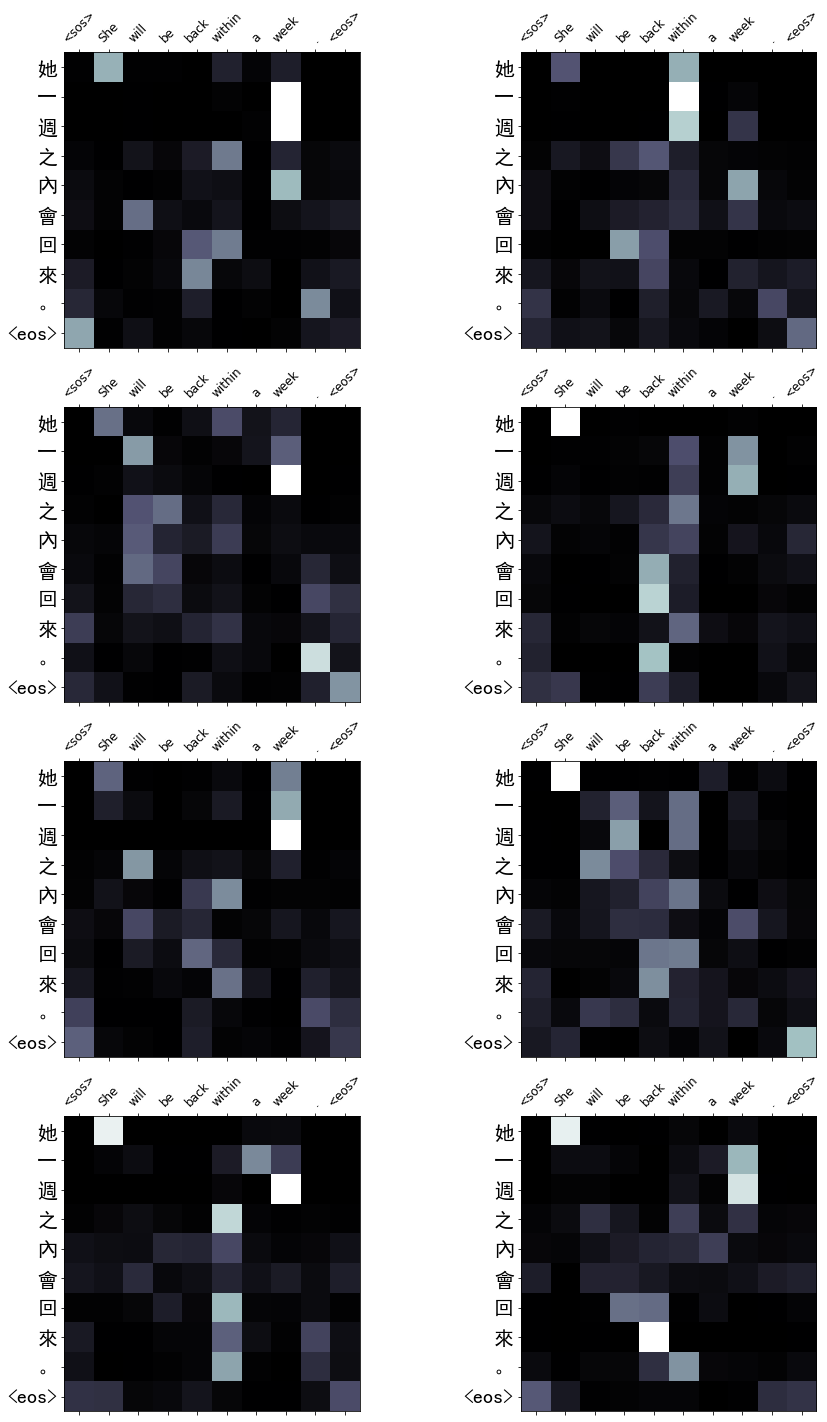

In [32]:
translate_and_show_attention('She will be back within a week.')

['我', '爱', '您', '。', '<eos>']


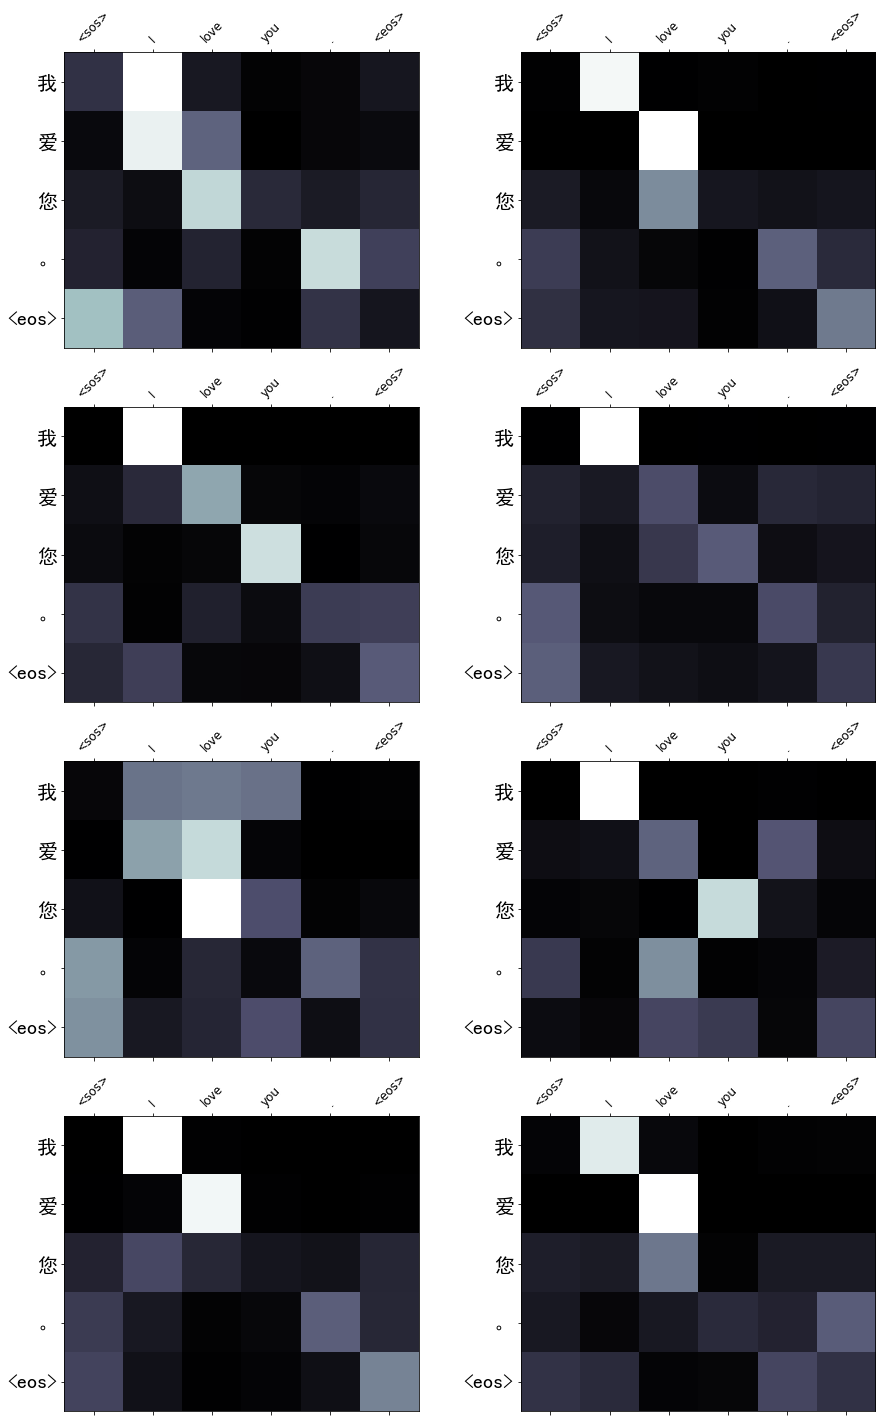

In [33]:
translate_and_show_attention('I love you.')

['他', '扔', '一', '塊', '石', '頭', '到', '池', '塘', '裡', '。', '<eos>']


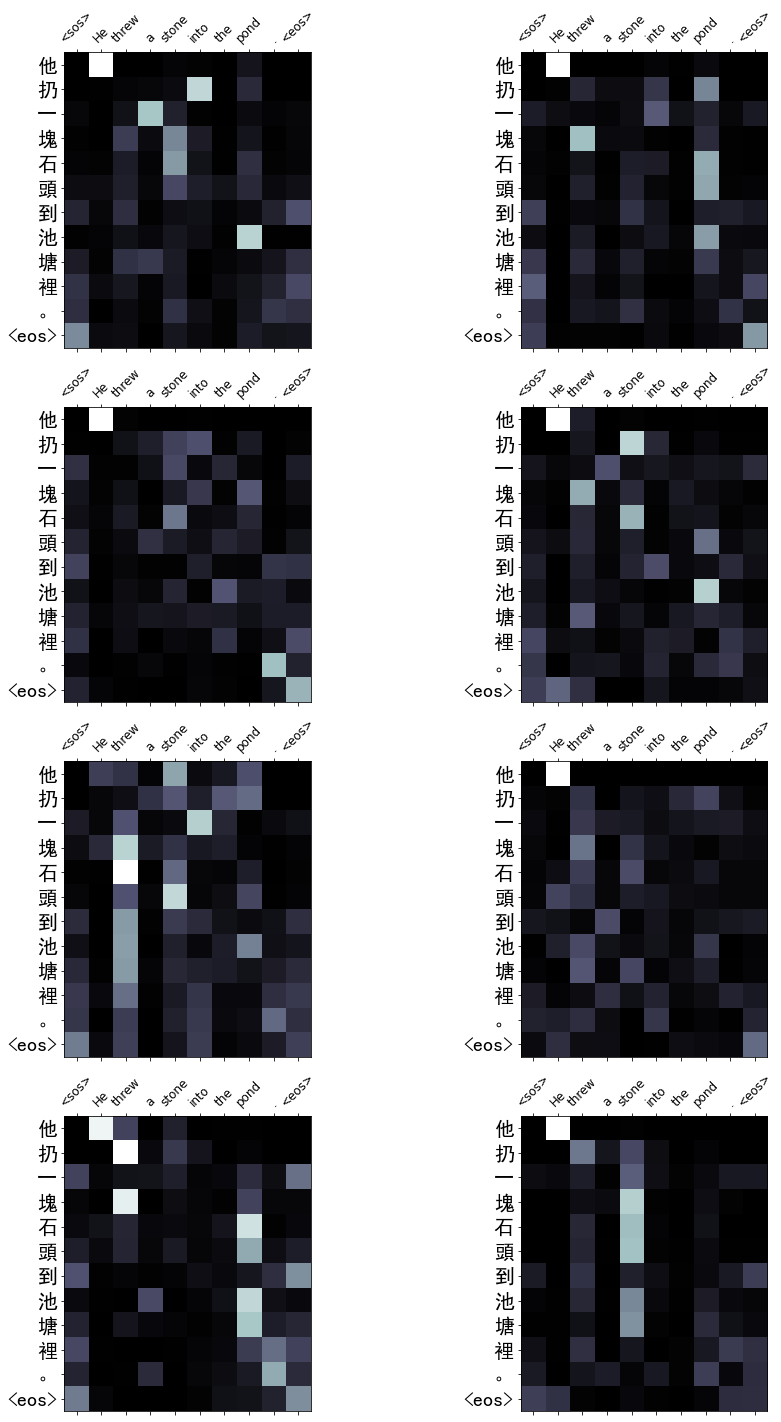

In [35]:
translate_and_show_attention('He threw a stone into the pond.')

['我', '們', '要', '問', '湯', '姆', '，', '看', '看', '看', '他', '怎', '麼', '想', '。', '<eos>']


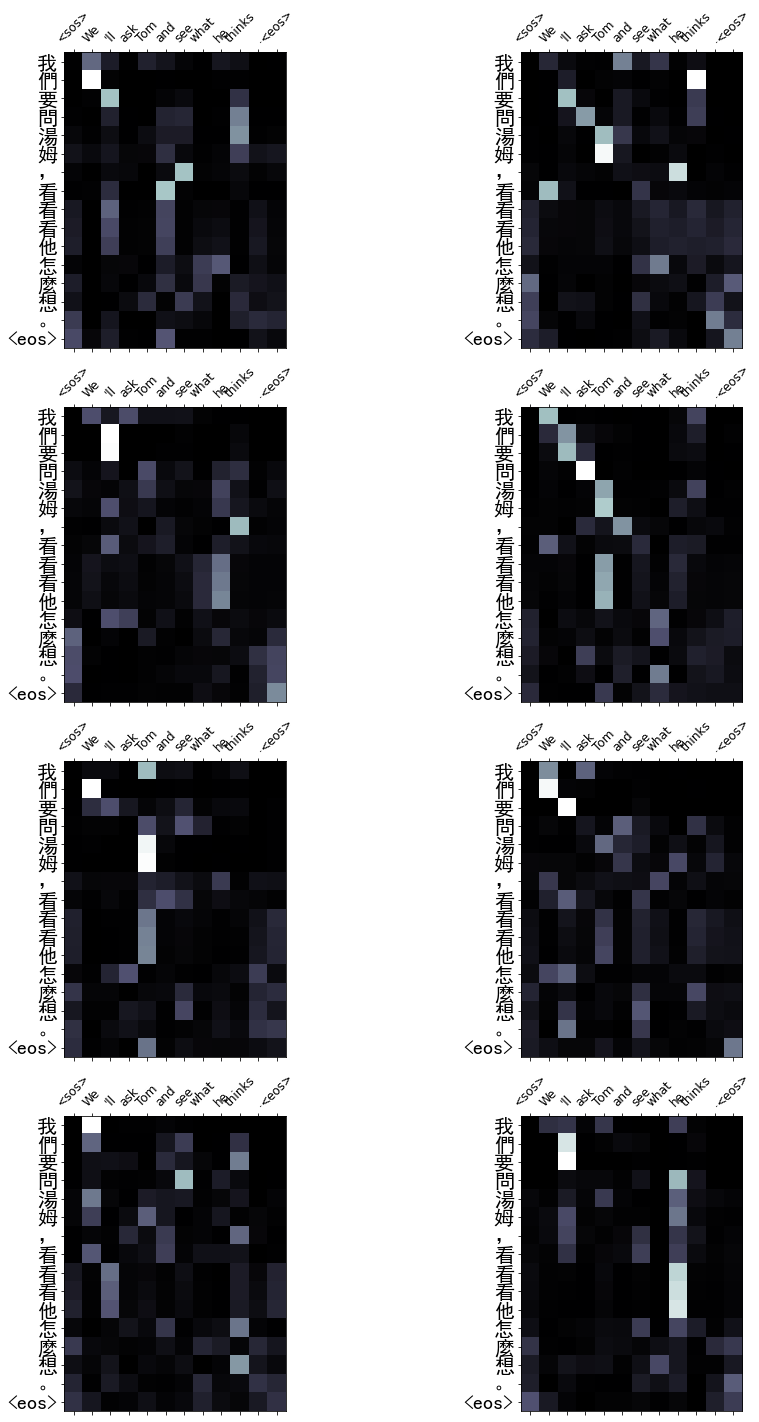

In [36]:
translate_and_show_attention('We\'ll ask Tom and see what he thinks.')

['他', '受', '不', '了', '咖', '啡', '的', '苦', '味', '。', '<eos>']


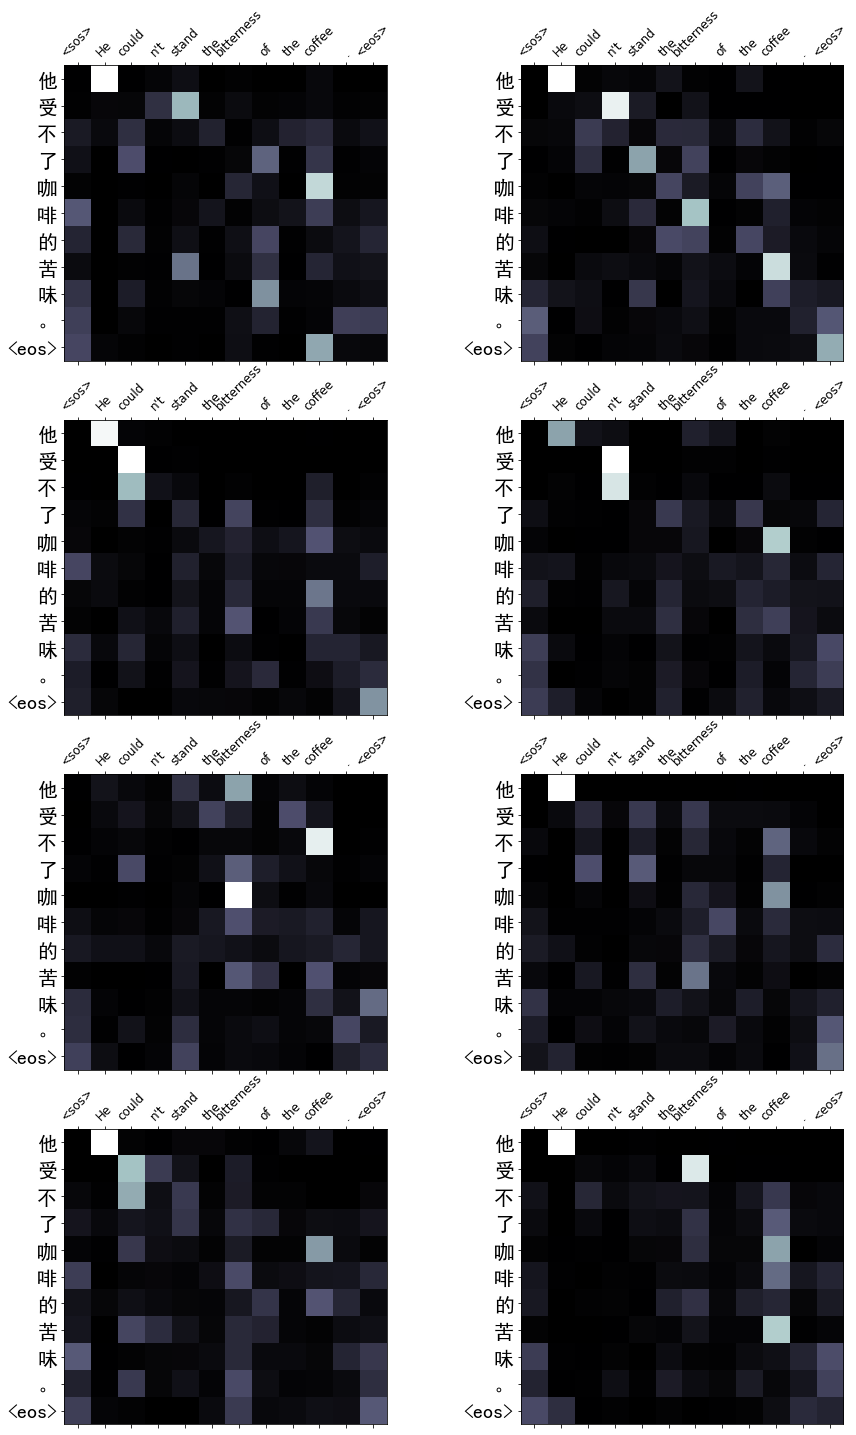

In [37]:
translate_and_show_attention('He couldn\'t stand the bitterness of the coffee.')

['我', '從', '來', '沒', '有', '看', '過', '他', '穿', '牛', '仔', '褲', '。', '<eos>']


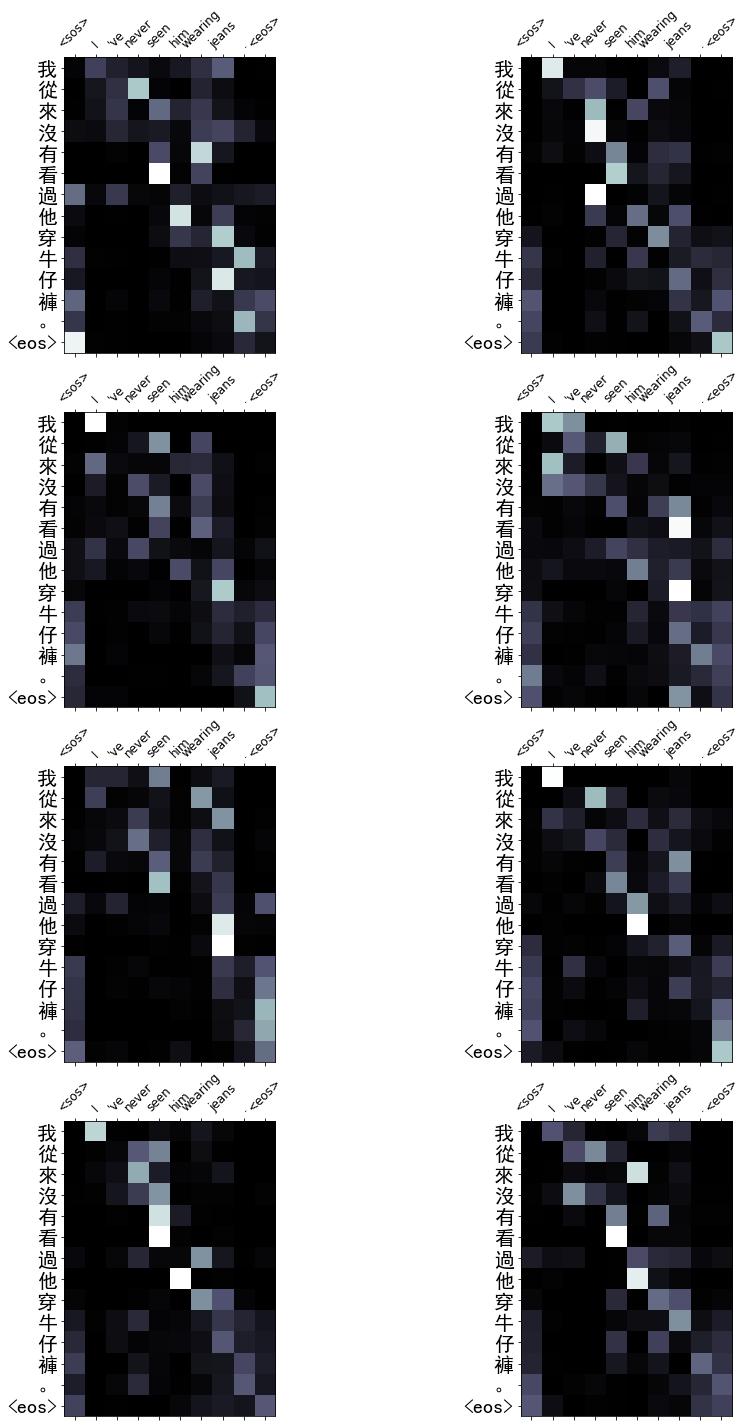

In [38]:
translate_and_show_attention('I\'ve never seen him wearing jeans.')

['我', '們', '下', '棋', '玩', '得', '很', '開', '心', '。', '<eos>']


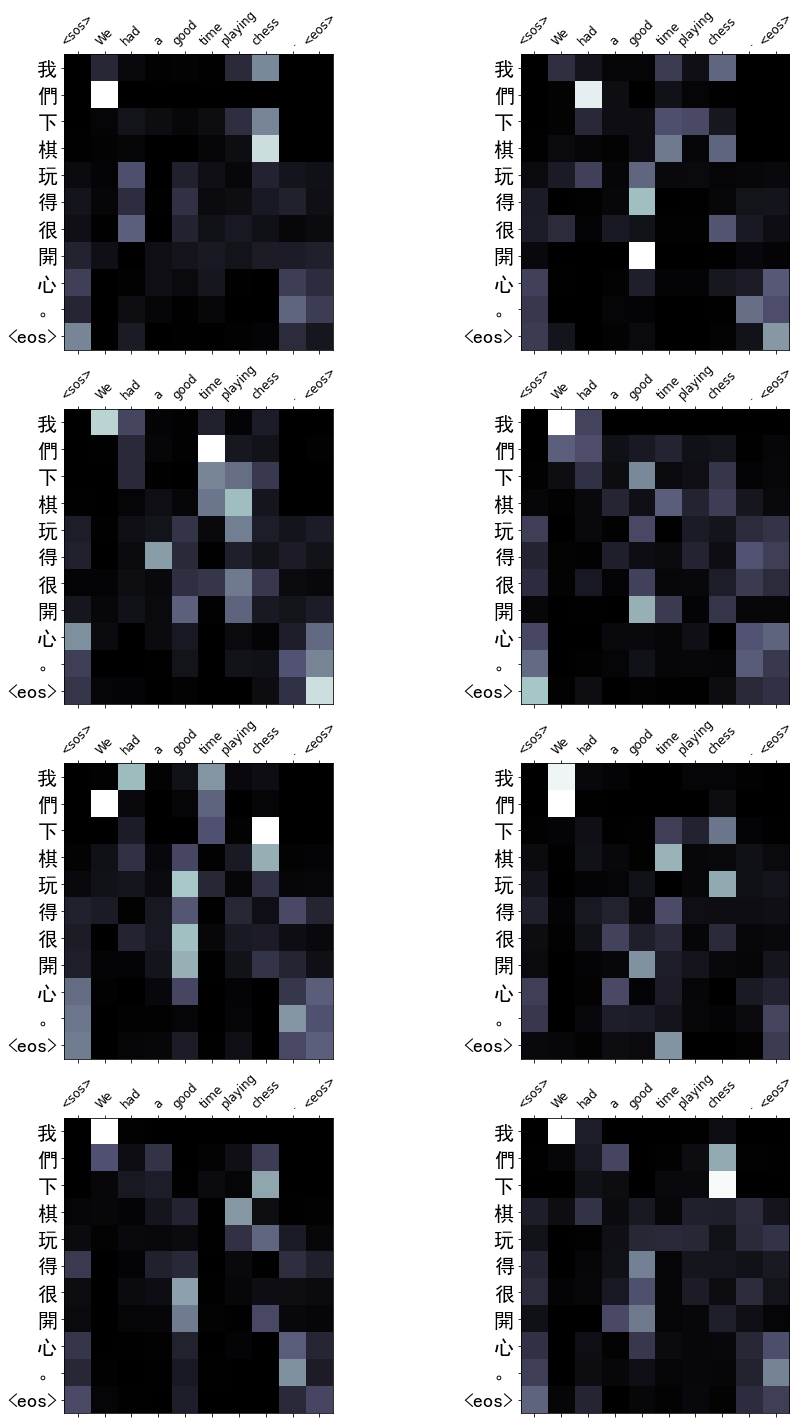

In [39]:
translate_and_show_attention('We had a good time playing chess.')

['星', '期', '天', '的', '時', '候', '，', '你', '不', '用', '工', '作', '。', '<eos>']


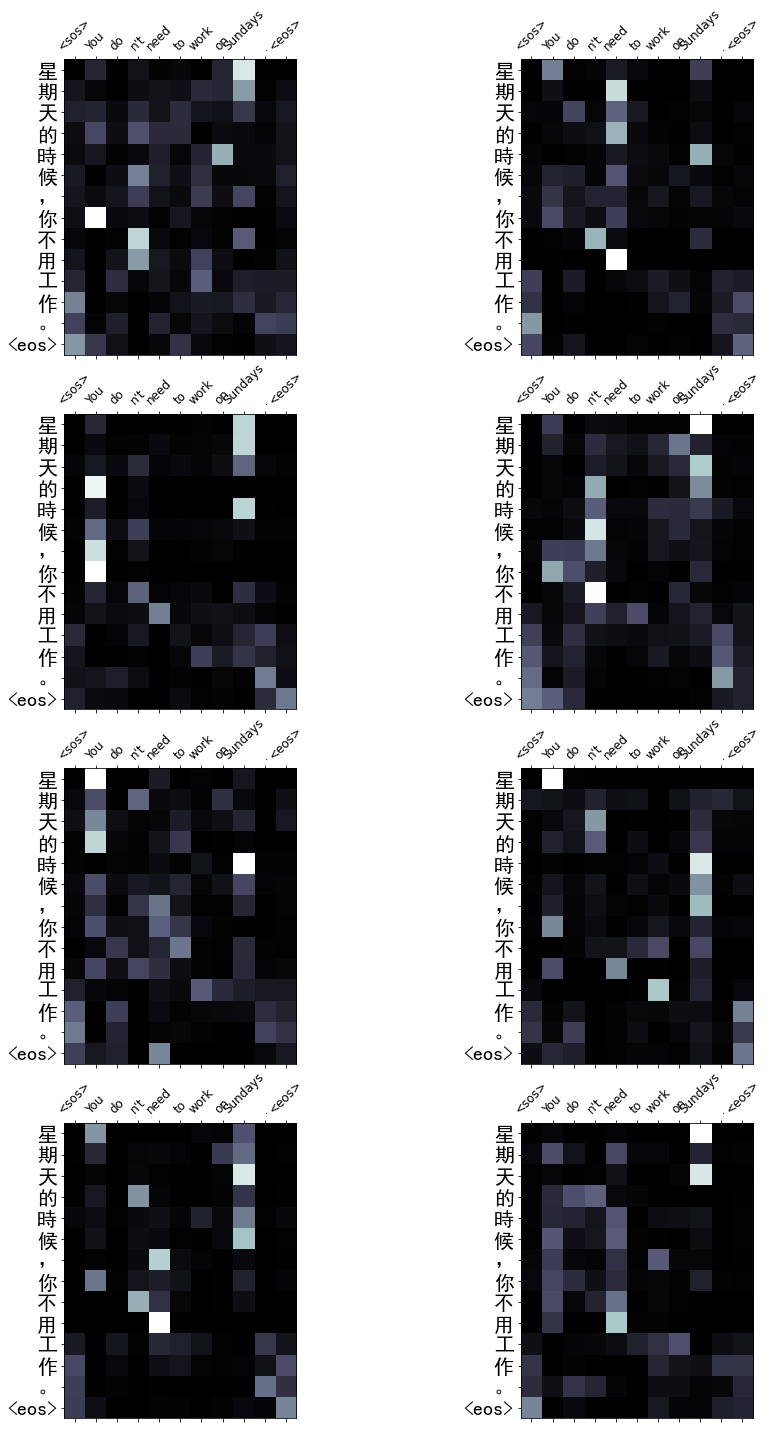

In [40]:
translate_and_show_attention('You don\'t need to work on Sundays.')

['他', '告', '诉', '我', '他', '那', '时', '很', '忙', '。', '<eos>']


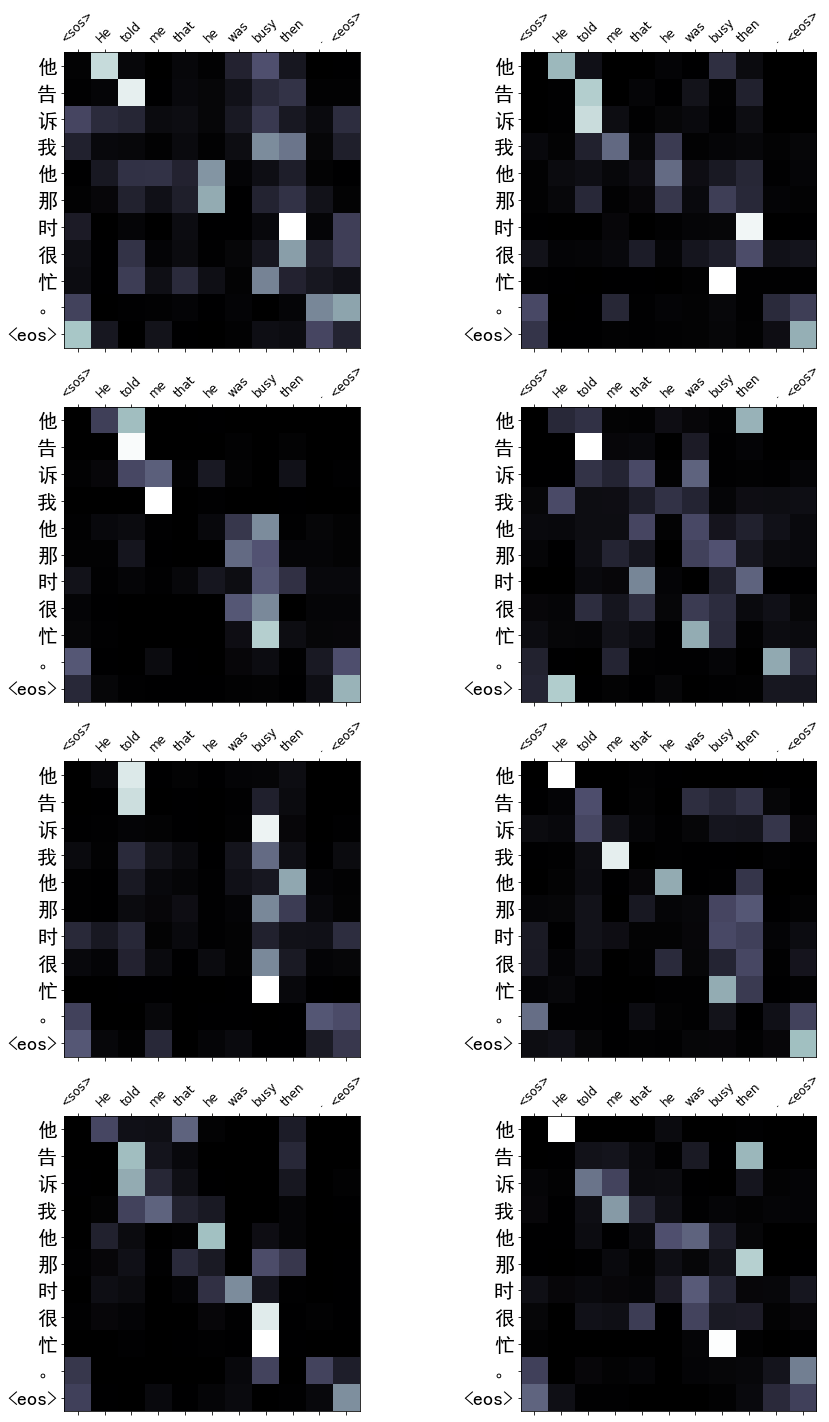

In [41]:
translate_and_show_attention('He told me that he was busy then.')

['即', '使', '我', '知', '道', '答', '案', '，', '我', '也', '不', '会', '告', '诉', '你', '。', '<eos>']


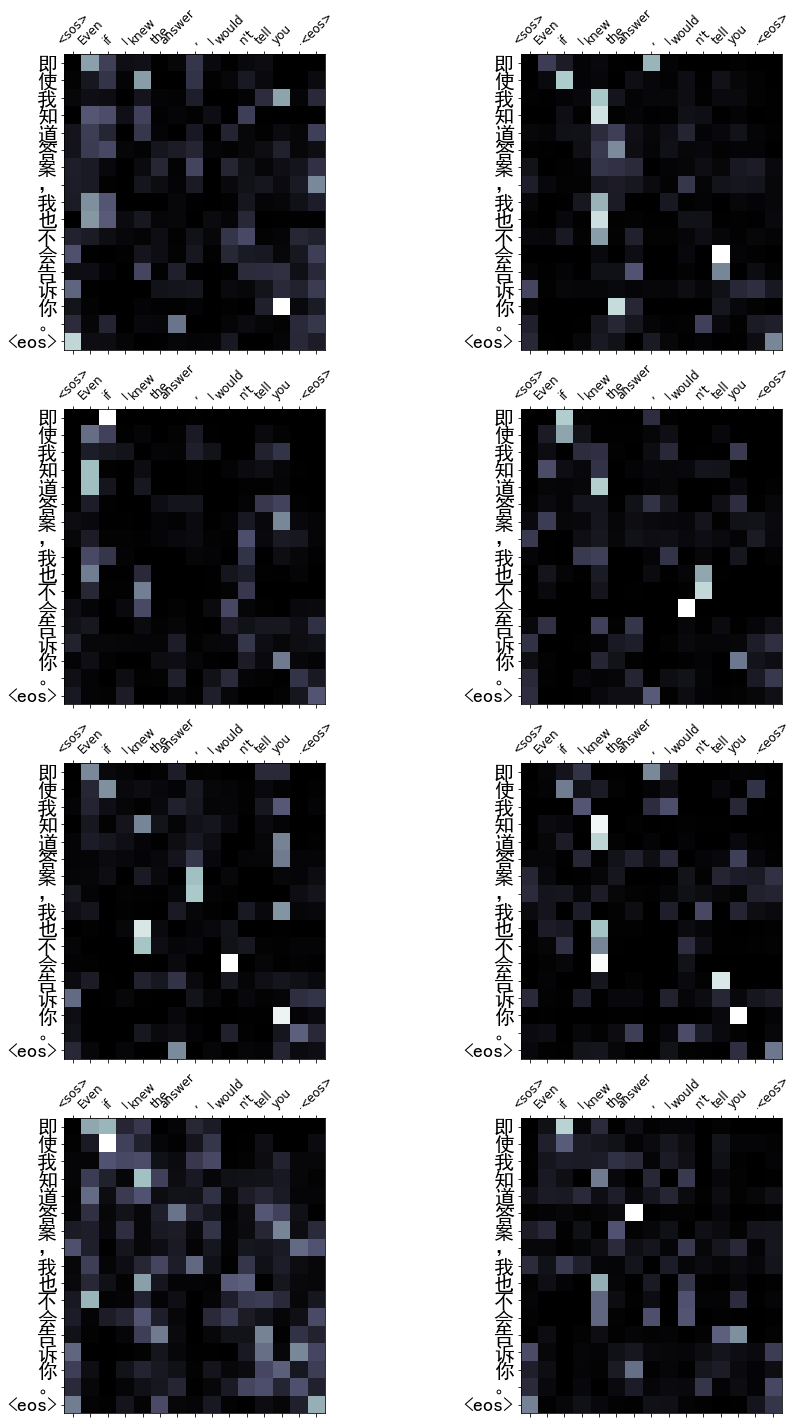

In [42]:
translate_and_show_attention('Even if I knew the answer, I wouldn\'t tell you.')